# 축구선수 몸값 크롤링 및 분석

## 1. 웹크롤링

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

playerDic = {'name':[], 'position':[], 'age':[], 'national':[], 'club':[], 'marketValue':[]}

for i in range(1,5):
    url = "https://www.transfermarkt.com/marktwertetop/wertvollstespieler?ajax=yw1&page={}".format(i)
    
    #url = "https://www.transfermarkt.com/spieler-statistik/wertvollstespieler/marktwertetop"
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36",
              "Accept-Language":"ko-KR,ko"}
    res = requests.get(url, headers=headers)
    res.raise_for_status()
    soup =BeautifulSoup(res.text, "lxml")

    players = soup.find_all("tr", class_=["odd", "even"])

    # 환율
    url = "https://search.naver.com/search.naver?where=nexearch&sm=top_sug.ase&fbm=0&acr=1&acq=%EC%9C%A0%EB%A1%9C&qdt=0&ie=utf8&query=%EC%9C%A0%EB%A1%9C"
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36",
              "Accept-Language":"ko-KR,ko"}
    res = requests.get(url, headers=headers)
    res.raise_for_status()
    soup =BeautifulSoup(res.text, "lxml")

    exchangeRate = soup.find_all('div', class_='rate_tlt')[0].strong.get_text().replace(',','')
    exchangeRate = round(float(exchangeRate))

    for player in players:
        player = player.find_all('td')
    
        playerDic['name'].append(player[3].get_text())
        playerDic['position'].append(player[4].get_text())
        playerDic['age'].append(player[5].get_text())
        playerDic['national'].append(player[6].img['alt'])
        playerDic['club'].append(player[7].img['alt'])
        mv = player[8].get_text()
        mv = mv.replace('€','')
        mv = mv.replace('m','')
        mv = round(float(mv))
        playerDic['marketValue'].append(str(int(mv*exchangeRate/100))+'억')



### 1.1. Data frame 만들기

In [2]:
playerDf = pd.DataFrame(playerDic)
playerDf

,name,position,age,national,club,marketValue
0,Kylian Mbappé,Centre-Forward,22,France,Paris Saint-Germain,2217억
1,Erling Haaland,Centre-Forward,21,Norway,Borussia Dortmund,1801억
2,Harry Kane,Centre-Forward,28,England,Tottenham Hotspur,1663억
3,Jadon Sancho,Right Winger,21,England,Manchester United,1386억
4,Mohamed Salah,Right Winger,29,Egypt,Liverpool FC,1386억
...,...,...,...,...,...,...
95,Fabián Ruiz,Central Midfield,25,Spain,SSC Napoli,623억
96,Diogo Jota,Left Winger,24,Portugal,Liverpool FC,623억
97,Diego Carlos,Centre-Back,28,Brazil,Sevilla FC,623억
98,Caglar Söyüncü,Centre-Back,25,Turkey,Leicester City,623억


### 1.2. 저장하기

In [3]:
playerDf.to_csv("data4/transfermarket.csv", index=False)
playerDf.to_excel("data4/transfermarket.xlsx",encoding='utf-8', index=False)

### 1.3. 환율 가져오기(유로)

In [9]:
exchange_url = 'https://search.naver.com/search.naver?where=nexearch&sm=top_sug.ase&fbm=0&acr=1&acq=%EC%9C%A0%EB%A1%9C&qdt=0&ie=utf8&query=%EC%9C%A0%EB%A1%9C'
exchange_res = requests.get(exchange_url, headers=headers)
print('exchange : ', exchange_res.status_code)

exchange_soup = BeautifulSoup(exchange_res.text, 'lxml')
exchangeRate = exchange_soup.find('span', class_='spt_con up').strong.get_text().replace(',','')
exchangeRate

exchange :  200


'1386.03'

### 1.4. 대륙 정보 가져오기

In [11]:
ctn = pd.read_csv('data4/nation_final.csv')
ctn

,name,area,eng
0,가나,아프리카,Ghana
1,가봉,아프리카,Gabon
2,가이아나,아메리카,NaN
3,감비아,아프리카,NaN
4,과테말라,아메리카,NaN
...,...,...,...
188,피지,오세아니아,NaN
189,핀란드,유럽,NaN
190,필리핀,아시아,NaN
191,헝가리,유럽,Hungary


In [12]:
insert_data = {'name':['미국','대한민국','스코틀랜드','웨일스','콩고민주공화국','보스니아 헤르체고비나','감비아'],
               'area':['아메리카','아시아','유럽','유럽','아프리카','유럽','아프리카'],
               'eng':['United States','Korea, South','Scotland','Wales','DR Congo','Bosnia-Herzegovina','The Gambia']}
df_insert_data = pd.DataFrame(insert_data)
ctn = ctn.append(df_insert_data, ignore_index=True)
ctn


,name,area,eng
0,가나,아프리카,Ghana
1,가봉,아프리카,Gabon
2,가이아나,아메리카,NaN
3,감비아,아프리카,NaN
4,과테말라,아메리카,NaN
...,...,...,...
195,스코틀랜드,유럽,Scotland
196,웨일스,유럽,Wales
197,콩고민주공화국,아프리카,DR Congo
198,보스니아 헤르체고비나,유럽,Bosnia-Herzegovina


In [13]:
ctn = ctn.rename(columns={'eng':'national'})
ctn_copy = ctn.drop('name', axis=1)
ctn_copy

,area,national
0,아프리카,Ghana
1,아프리카,Gabon
2,아메리카,NaN
3,아프리카,NaN
4,아메리카,NaN
...,...,...
195,유럽,Scotland
196,유럽,Wales
197,아프리카,DR Congo
198,유럽,Bosnia-Herzegovina


### 1.5. 두 DataFrame 합병 > 대륙 컬럼 추가

In [14]:
df_players = pd.merge(playerDf, ctn_copy, how='left', on='national')
df_players.index=df_players.index+1
df_players.head()

,name,position,age,national,club,marketValue,area
1,Kylian Mbappé,Centre-Forward,22,France,Paris Saint-Germain,2217억,유럽
2,Erling Haaland,Centre-Forward,21,Norway,Borussia Dortmund,1801억,유럽
3,Harry Kane,Centre-Forward,28,England,Tottenham Hotspur,1663억,유럽
4,Jadon Sancho,Right Winger,21,England,Manchester United,1386억,유럽
5,Mohamed Salah,Right Winger,29,Egypt,Liverpool FC,1386억,아프리카


In [15]:
df = df_players.copy()

In [16]:
df = df.rename(columns={'marketValue':'marketValue(단위:억)'})
df.head()

,name,position,age,national,club,marketValue(단위:억),area
1,Kylian Mbappé,Centre-Forward,22,France,Paris Saint-Germain,2217억,유럽
2,Erling Haaland,Centre-Forward,21,Norway,Borussia Dortmund,1801억,유럽
3,Harry Kane,Centre-Forward,28,England,Tottenham Hotspur,1663억,유럽
4,Jadon Sancho,Right Winger,21,England,Manchester United,1386억,유럽
5,Mohamed Salah,Right Winger,29,Egypt,Liverpool FC,1386억,아프리카


In [17]:
df['marketValue(단위:억)'] = df['marketValue(단위:억)'].str.replace('억','')
df['marketValue(단위:억)'] = df['marketValue(단위:억)'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 100
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               100 non-null    object
 1   position           100 non-null    object
 2   age                100 non-null    object
 3   national           100 non-null    object
 4   club               100 non-null    object
 5   marketValue(단위:억)  100 non-null    int32 
 6   area               100 non-null    object
dtypes: int32(1), object(6)
memory usage: 5.9+ KB


In [21]:
df['age'] = df['age'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 100
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               100 non-null    object
 1   position           100 non-null    object
 2   age                100 non-null    int32 
 3   national           100 non-null    object
 4   club               100 non-null    object
 5   marketValue(단위:억)  100 non-null    int32 
 6   area               100 non-null    object
dtypes: int32(2), object(5)
memory usage: 5.5+ KB


### 1.6. 연령대 추가

In [18]:
df.sort_values('age')

,name,position,age,national,club,marketValue(단위:억),area
95,Florian Wirtz,Attacking Midfield,18,Germany,Bayer 04 Leverkusen,623,유럽
67,Jude Bellingham,Central Midfield,18,England,Borussia Dortmund,762,유럽
66,Eduardo Camavinga,Central Midfield,18,France,Real Madrid,762,유럽
48,Ansu Fati,Left Winger,18,Spain,FC Barcelona,831,유럽
16,Pedri,Central Midfield,18,Spain,FC Barcelona,1108,유럽
...,...,...,...,...,...,...,...
74,Virgil van Dijk,Centre-Back,30,Netherlands,Liverpool FC,762,유럽
59,Antoine Griezmann,Second Striker,30,France,Atlético de Madrid,831,유럽
72,N'Golo Kanté,Defensive Midfield,30,France,Chelsea FC,762,유럽
65,Robert Lewandowski,Centre-Forward,33,Poland,Bayern Munich,831,유럽


In [22]:
def age_group(age):
    if age<20 : return '10대'
    elif age<30 : return '20대'
    else : return '30대'

In [23]:
df['age_group'] = df['age'].apply(age_group)

In [24]:
df.head()

,name,position,age,national,club,marketValue(단위:억),area,age_group
1,Kylian Mbappé,Centre-Forward,22,France,Paris Saint-Germain,2217,유럽,20대
2,Erling Haaland,Centre-Forward,21,Norway,Borussia Dortmund,1801,유럽,20대
3,Harry Kane,Centre-Forward,28,England,Tottenham Hotspur,1663,유럽,20대
4,Jadon Sancho,Right Winger,21,England,Manchester United,1386,유럽,20대
5,Mohamed Salah,Right Winger,29,Egypt,Liverpool FC,1386,아프리카,20대


In [27]:
df.to_csv('data4/transfermarket_final.csv', index=False)

In [28]:
df = pd.read_csv('data4/transfermarket_final.csv')
df.head()

,Unnamed: 0,name,position,age,national,club,marketValue(단위:억),area,age_group
0,1,Kylian Mbappé,Centre-Forward,22,France,Paris Saint-Germain,2217,유럽,20대
1,2,Erling Haaland,Centre-Forward,21,Norway,Borussia Dortmund,1801,유럽,20대
2,3,Harry Kane,Centre-Forward,28,England,Tottenham Hotspur,1663,유럽,20대
3,4,Jadon Sancho,Right Winger,21,England,Manchester United,1386,유럽,20대
4,5,Mohamed Salah,Right Winger,29,Egypt,Liverpool FC,1386,아프리카,20대


## 2. 데이터 분석 & 시각화

### 2.1. 기초분석

In [29]:
# 1등 선수
df.loc[0,'name']

'Kylian Mbappé'

In [31]:
# 30세 이상인 선수 
df.loc[df['age']>=30, ['name','marketValue(단위:억)']]

,name,marketValue(단위:억)
6,Kevin De Bruyne,1386
20,Lionel Messi,1108
58,Antoine Griezmann,831
64,Robert Lewandowski,831
71,N'Golo Kanté,762
73,Virgil van Dijk,762
92,Lorenzo Insigne,665
93,Kalidou Koulibaly,665


In [32]:
# 나이별로 정렬
df.sort_values('age',ascending=False)

,Unnamed: 0,name,position,age,national,club,marketValue(단위:억),area,age_group
20,21,Lionel Messi,Right Winger,34,Argentina,Paris Saint-Germain,1108,아메리카,30대
64,65,Robert Lewandowski,Centre-Forward,33,Poland,Bayern Munich,831,유럽,30대
73,74,Virgil van Dijk,Centre-Back,30,Netherlands,Liverpool FC,762,유럽,30대
71,72,N'Golo Kanté,Defensive Midfield,30,France,Chelsea FC,762,유럽,30대
6,7,Kevin De Bruyne,Attacking Midfield,30,Belgium,Manchester City,1386,유럽,30대
...,...,...,...,...,...,...,...,...,...
47,48,Ansu Fati,Left Winger,18,Spain,FC Barcelona,831,유럽,10대
94,95,Florian Wirtz,Attacking Midfield,18,Germany,Bayer 04 Leverkusen,623,유럽,10대
15,16,Pedri,Central Midfield,18,Spain,FC Barcelona,1108,유럽,10대
66,67,Jude Bellingham,Central Midfield,18,England,Borussia Dortmund,762,유럽,10대


- Top 100 선수들의 평균나이

In [33]:
df['age'].mean()

25.13

- 선수들이 가장 많이 속한 나라

In [37]:
print(df['national'].mode())
print(type(df['national'].mode()))

0    England
dtype: object
<class 'pandas.core.series.Series'>


In [38]:
df[df['national'] == df['national'].mode()[0]]['marketValue(단위:억)'].count()

14

- 나라별 선수현황

In [92]:
# 국적별로 분류
g1 = df.groupby('national').head(10)
g1

,Unnamed: 0,name,position,age,national,club,marketValue(단위:억),area,age_group
0,1,Kylian Mbappé,Centre-Forward,22,France,Paris Saint-Germain,2217,유럽,20대
1,2,Erling Haaland,Centre-Forward,21,Norway,Borussia Dortmund,1801,유럽,20대
2,3,Harry Kane,Centre-Forward,28,England,Tottenham Hotspur,1663,유럽,20대
3,4,Jadon Sancho,Right Winger,21,England,Manchester United,1386,유럽,20대
4,5,Mohamed Salah,Right Winger,29,Egypt,Liverpool FC,1386,아프리카,20대
...,...,...,...,...,...,...,...,...,...
95,96,Fabián Ruiz,Central Midfield,25,Spain,SSC Napoli,623,유럽,20대
96,97,Diogo Jota,Left Winger,24,Portugal,Liverpool FC,623,유럽,20대
97,98,Diego Carlos,Centre-Back,28,Brazil,Sevilla FC,623,아메리카,20대
98,99,Caglar Söyüncü,Centre-Back,25,Turkey,Leicester City,623,유럽,20대


In [91]:
g1 = g1.sort_values(ascending=False).head(10)
g1

0     2217
1     1801
2     1663
3     1386
4     1386
5     1386
6     1386
7     1386
10    1247
11    1247
Name: marketValue(단위:억), dtype: int64

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# 폰트설정
plt.rcParams['font.family']='Malgun Gothic'

# - 부호가 깨질때
plt.rcParams['axes.unicode_minus'] = False

# 캔버스 사이즈 설정
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
g2 = 

### 2.2 대륙별 선수 현황

In [53]:
g3 = df.groupby('area')['marketValue(단위:억)'].count().sort_values(ascending=False)
g3

area
유럽      74
아메리카    18
아프리카     7
아시아      1
Name: marketValue(단위:억), dtype: int64

In [43]:
k_df = pd.read_csv('data4/koreaPlayers.csv', index_col=0)
k_df

,name,position,age,national,club,marketValue(단위:억),area
1,Heung-min Son,Left Winger,29,"Korea, South",Tottenham Hotspur,1174,아시아
2,Hee-chan Hwang,Centre-Forward,25,"Korea, South",Wolverhampton Wanderers,152,아시아
3,Kang-in Lee,Attacking Midfield,20,"Korea, South",RCD Mallorca,138,아시아
4,Ui-jo Hwang,Centre-Forward,29,"Korea, South",FC Girondins Bordeaux,69,아시아
5,Woo-yeong Jeong,Right Winger,21,"Korea, South",SC Freiburg,41,아시아
...,...,...,...,...,...,...,...
96,Geon-ung Kim,Defensive Midfield,24,"Korea, South",Suwon FC,8,아시아
97,Dae-won Kim,Centre-Forward,24,"Korea, South",Gangwon FC,8,아시아
98,Dong-hyeon Kim,Defensive Midfield,24,"Korea, South",Gangwon FC,8,아시아
99,Won-sang Um,Right Winger,22,"Korea, South",Gwangju FC,8,아시아


In [47]:
df.loc[df['area']=='아시아/유럽']

,Unnamed: 0,name,position,age,national,club,marketValue(단위:억),area,age_group
98,99,Caglar Söyüncü,Centre-Back,25,Turkey,Leicester City,623,아시아/유럽,20대


In [52]:
df.loc[df['area']=='아시아/유럽','area']= '유럽'

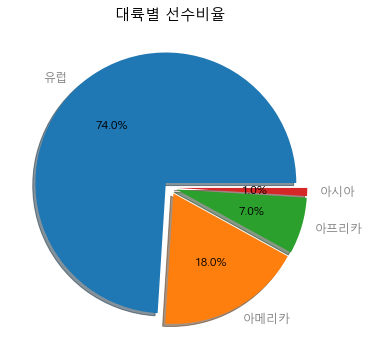

In [54]:
ex = (0.05, 0.05, 0.05, 0.05)
patchs, texts, autotexts = plt.pie(g3,
                                   explode= ex,
                                   labels = g3.index,
                                   autopct= '%0.1f%%',
                                  shadow= True,
                                  startangle=0)

plt.title('대륙별 선수비율', fontsize = 15)

# label 텍스트에 대한 스타일 적용
for t in texts :
    t.set_fontsize(12)
    t.set_color('gray')

# pie 위의 텍스트에 대한 스타일 적용
for t in autotexts :
    t.set_fontsize(12)
    #t.set_color('white')
    
plt.show()

### 2.3. 클럽별 선수현황

In [59]:
g1 = df.groupby('club')['marketValue(단위:억)'].count().sort_values(ascending=False).head(10).to_frame()
g1

,marketValue(단위:억)
club,
Manchester City,11
Liverpool FC,9
Bayern Munich,8
Paris Saint-Germain,7
Manchester United,7
Atlético de Madrid,6
Chelsea FC,6
SSC Napoli,6
Real Madrid,6


<AxesSubplot:xlabel='marketValue(단위:억)', ylabel='club'>

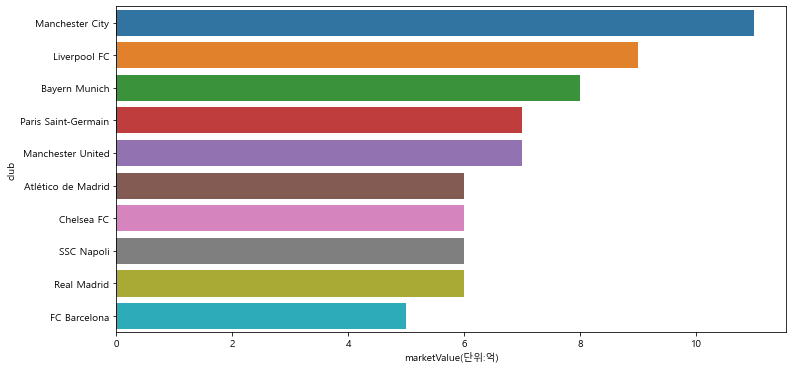

In [60]:
sns.barplot(data=g1, x='marketValue(단위:억)', y=g1.index)

In [61]:
g2 = df.groupby('club')['marketValue(단위:억)'].sum().sort_values(ascending=False).head(10).to_frame()
g2

,marketValue(단위:억)
club,
Manchester City,10599
Liverpool FC,8243
Paris Saint-Germain,8243
Bayern Munich,7550
Manchester United,6998
Chelsea FC,5750
Atlético de Madrid,5679
Real Madrid,4918
FC Barcelona,4710


<AxesSubplot:xlabel='marketValue(단위:억)', ylabel='club'>

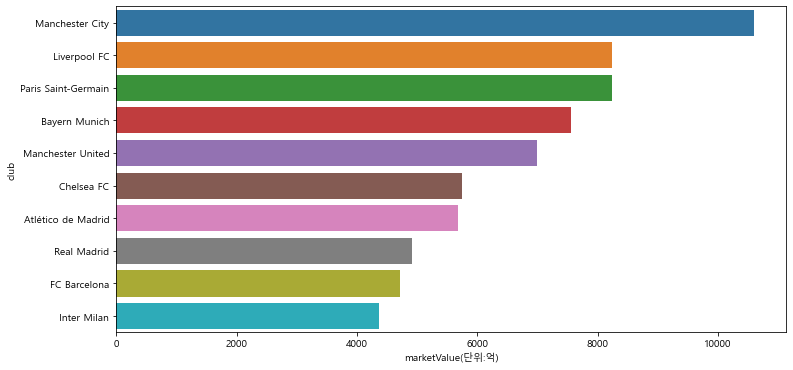

In [62]:
sns.barplot(data=g2, x='marketValue(단위:억)', y=g2.index)

### 2.4. 연령대별 선수현황

In [63]:
g1 = df.groupby('age_group')['marketValue(단위:억)'].count()
g1

age_group
10대     6
20대    86
30대     8
Name: marketValue(단위:억), dtype: int64

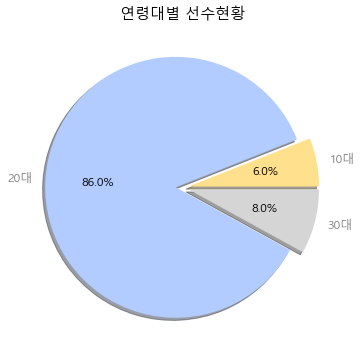

In [68]:
ex = (0.05, 0.05, 0.05)

colors = ['#FFE08C','#B2CCFF','#D5D5D5']
patchs, texts, autotexts = plt.pie(g1,
                                   explode= ex,
                                   labels = g1.index,
                                   autopct= '%0.1f%%',
                                  shadow= True,
                                  startangle=0, colors=colors)

plt.title('연령대별 선수현황', fontsize = 15)

# label 텍스트에 대한 스타일 적용
for t in texts :
    t.set_fontsize(12)
    t.set_color('gray')

# pie 위의 텍스트에 대한 스타일 적용
for t in autotexts :
    t.set_fontsize(12)
    #t.set_color('white')
    
plt.show()

In [69]:
g2 = df.groupby('age_group')['marketValue(단위:억)'].sum()
g2

age_group
10대     4779
20대    80493
30대     7010
Name: marketValue(단위:억), dtype: int64

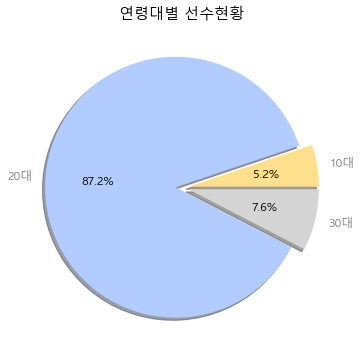

In [70]:
ex = (0.05, 0.05, 0.05)

colors = ['#FFE08C','#B2CCFF','#D5D5D5']
patchs, texts, autotexts = plt.pie(g2,
                                   explode= ex,
                                   labels = g2.index,
                                   autopct= '%0.1f%%',
                                  shadow= True,
                                  startangle=0, colors=colors)

plt.title('연령대별 선수현황', fontsize = 15)

# label 텍스트에 대한 스타일 적용
for t in texts :
    t.set_fontsize(12)
    t.set_color('gray')

# pie 위의 텍스트에 대한 스타일 적용
for t in autotexts :
    t.set_fontsize(12)
    #t.set_color('white')
    
plt.show()

<AxesSubplot:xlabel='marketValue(단위:억)', ylabel='club'>

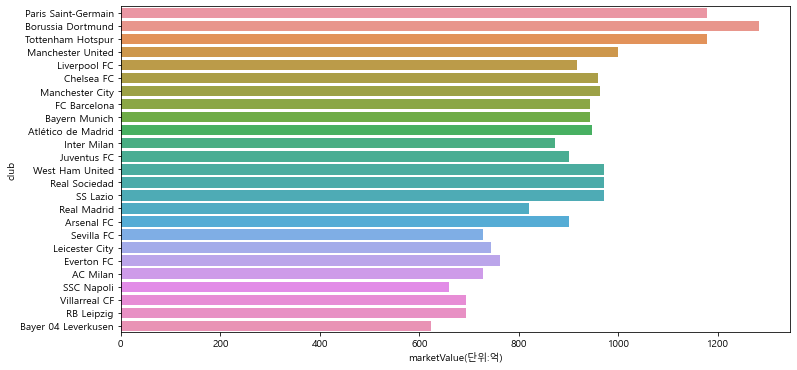

In [72]:
sns.barplot(data=df, x='marketValue(단위:억)', y='club', ci=None)

<AxesSubplot:xlabel='age_group', ylabel='marketValue(단위:억)'>

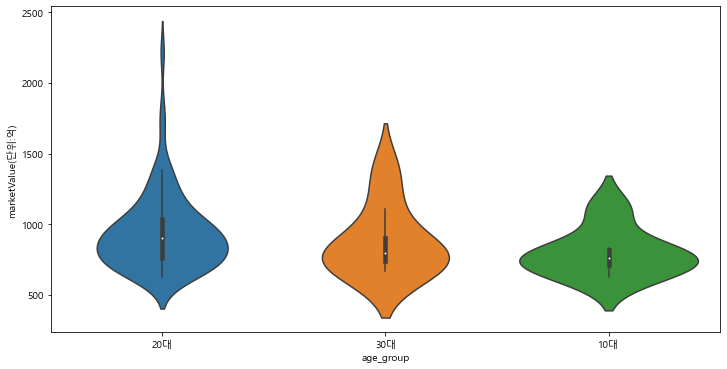

In [73]:
sns.violinplot(data=df, x='age_group', y='marketValue(단위:억)')

### 2.5. 포지션별 선수현황

<AxesSubplot:xlabel='position', ylabel='marketValue(단위:억)'>

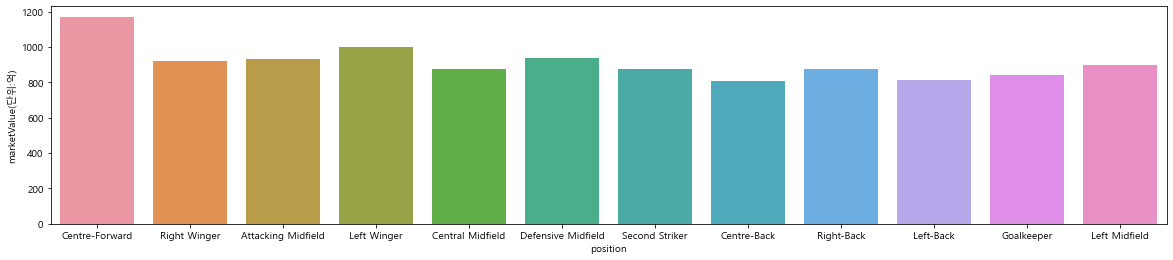

In [75]:
plt.figure(figsize=(20,4))
sns.barplot(data=df, x='position', y='marketValue(단위:억)', ci=None)

In [76]:
g1 = df.groupby('position')['marketValue(단위:억)'].count().sort_values(ascending=False).head(10).to_frame()
g1

,marketValue(단위:억)
position,
Centre-Back,17
Central Midfield,16
Left Winger,13
Centre-Forward,11
Right Winger,10
Attacking Midfield,9
Defensive Midfield,7
Goalkeeper,6
Left-Back,4


<AxesSubplot:xlabel='marketValue(단위:억)', ylabel='position'>

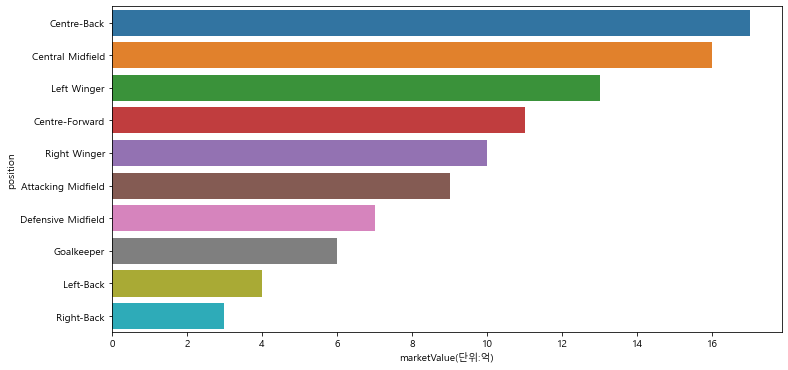

In [80]:
sns.barplot(data=g1, y=g1.index, x='marketValue(단위:억)', ci=None)

In [77]:
g2 = df.groupby('position')['marketValue(단위:억)'].sum().sort_values(ascending=False).head(10).to_frame()
g2

,marketValue(단위:억)
position,
Central Midfield,13991
Centre-Back,13756
Left Winger,12995
Centre-Forward,12885
Right Winger,9215
Attacking Midfield,8383
Defensive Midfield,6581
Goalkeeper,5056
Left-Back,3256


<AxesSubplot:xlabel='marketValue(단위:억)', ylabel='position'>

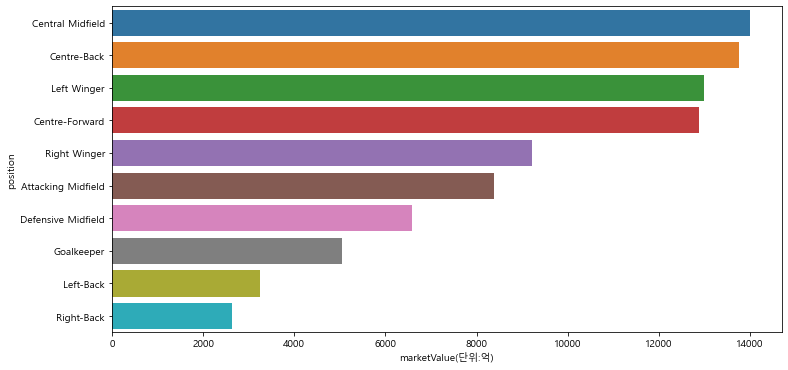

In [81]:
sns.barplot(data=g2, y=g2.index, x='marketValue(단위:억)', ci=None)

In [83]:
df.head(10)

,Unnamed: 0,name,position,age,national,club,marketValue(단위:억),area,age_group
0,1,Kylian Mbappé,Centre-Forward,22,France,Paris Saint-Germain,2217,유럽,20대
1,2,Erling Haaland,Centre-Forward,21,Norway,Borussia Dortmund,1801,유럽,20대
2,3,Harry Kane,Centre-Forward,28,England,Tottenham Hotspur,1663,유럽,20대
3,4,Jadon Sancho,Right Winger,21,England,Manchester United,1386,유럽,20대
4,5,Mohamed Salah,Right Winger,29,Egypt,Liverpool FC,1386,아프리카,20대
5,6,Romelu Lukaku,Centre-Forward,28,Belgium,Chelsea FC,1386,유럽,20대
6,7,Kevin De Bruyne,Attacking Midfield,30,Belgium,Manchester City,1386,유럽,30대
7,8,Neymar,Left Winger,29,Brazil,Paris Saint-Germain,1386,아메리카,20대
8,9,Frenkie de Jong,Central Midfield,24,Netherlands,FC Barcelona,1247,유럽,20대
9,10,Bruno Fernandes,Attacking Midfield,27,Portugal,Manchester United,1247,유럽,20대


In [86]:
g2 = df.iloc[0:25].groupby('position')['marketValue(단위:억)'].count().sort_values(ascending=False).to_frame()
g2

,marketValue(단위:억)
position,
Left Winger,6
Centre-Forward,5
Attacking Midfield,3
Central Midfield,3
Right Winger,3
Centre-Back,2
Defensive Midfield,1
Right-Back,1
Second Striker,1


<AxesSubplot:xlabel='marketValue(단위:억)', ylabel='position'>

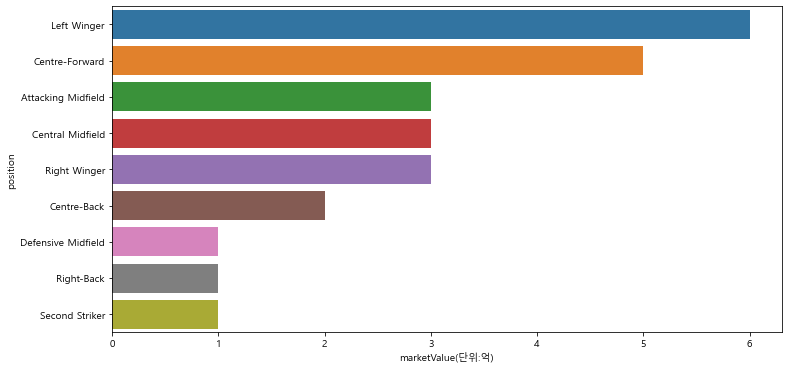

In [87]:
sns.barplot(data=g2, x='marketValue(단위:억)', y=g2.index, ci = None)

## 3. 과제 제출했던거

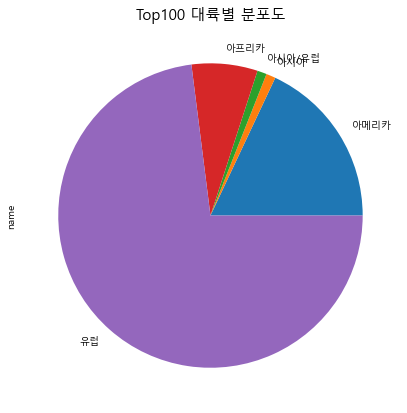

In [16]:
# Top100 선수들의 대륙 분포도
g = df.groupby(['area'])['name'].count()
g.plot(kind='pie', figsize=(7,7))

plt.title('Top100 대륙별 분포도', fontsize = 15)
plt.show()

# Top100 안에는 유럽 선수들이 압도적으로 많이 분포하고 있으며, 그 다음으로 아메리카, 아프리카, 아시아 순으로 분포하고 있다.

In [19]:
# 대륙별 나라별 시장가치 수치
area_nat_mv = df.groupby(['area','national'])['marketValue(단위:억)'].describe()
area_nat_mv

# Top100 안에 선수가 가장 많은 유럽국가 중에서는 

count         mean         std     min      25%     50%  \
area   national                                                                 
아메리카   Argentina        3.0   967.000000  239.023011   691.0   898.00  1105.0   
       Brazil          10.0   863.500000  221.588332   621.0   708.25   829.0   
       Canada           1.0   967.000000         NaN   967.0   967.00   967.0   
       Mexico           1.0   621.000000         NaN   621.0   621.00   621.0   
       United States    1.0   691.000000         NaN   691.0   691.00   691.0   
       Uruguay          2.0   863.500000   48.790368   829.0   846.25   863.5   
아시아    Korea, South     1.0  1174.000000         NaN  1174.0  1174.00  1174.0   
아시아/유럽 Turkey           1.0   621.000000         NaN   621.0   621.00   621.0   
아프리카   Cote d'Ivoire    1.0   760.000000         NaN   760.0   760.00   760.0   
       Egypt            1.0  1382.000000         NaN  1382.0  1382.00  1382.0   
       Morocco          1.0   829.000000         NaN   829.0   829.00   829.0   
       Nigeria          2.0   760.000000   97.580736   691.0   725.50   760.0   
       Senegal          2.0   918.500000  361.331565   663.0   790.75   918.5   
유럽     Austria          1.0   760.000000         NaN   760.0   760.00   760.0   
       Belgium          4.0  1088.250000  340.360960   760.0   811.75  1105.5   
       England         14.0  1021.357143  277.835482   691.0   794.50  1001.5   
       France          13.0   898.153846  403.862362   691.0   691.00   829.0   
       Germany          8.0   915.125000  176.154508   621.0   829.00   932.5   
       Italy            6.0   835.833333  110.093445   663.0   777.25   863.5   
       Netherlands      4.0   932.500000  255.082340   691.0   742.75   898.0   
       Norway           1.0  1796.000000         NaN  1796.0  1796.00  1796.0   
       Poland           2.0   760.000000   97.580736   691.0   725.50   760.0   
       Portugal         6.0   955.333333  228.792191   621.0   811.75  1001.5   
       Scotland         1.0   898.000000         NaN   898.0   898.00   898.0   
       Serbia           1.0   967.000000         NaN   967.0   967.00   967.0   
       Slovakia         1.0   829.000000         NaN   829.0   829.00   829.0   
       Slovenia         1.0   967.000000         NaN   967.0   967.00   967.0   
       Spain           10.0   849.600000  178.447751   621.0   691.00   829.0   

                          75%     max  
area   national                        
아메리카   Argentina      1105.00  1105.0  
       Brazil          932.50  1382.0  
       Canada          967.00   967.0  
       Mexico          621.00   621.0  
       United States   691.00   691.0  
       Uruguay         880.75   898.0  
아시아    Korea, South   1174.00  1174.0  
아시아/유럽 Turkey          621.00   621.0  
아프리카   Cote d'Ivoire   760.00   760.0  
       Egypt          1382.00  1382.0  
       Morocco         829.00   829.0  
       Nigeria         794.50   829.0  
       Senegal        1046.25  1174.0  
유럽     Austria         760.00   760.0  
       Belgium        1382.00  1382.0  
       England        1156.75  1658.0  
       France          829.00  2211.0  
       Germany         967.00  1243.0  
       Italy           898.00   967.0  
       Netherlands    1087.75  1243.0  
       Norway         1796.00  1796.0  
       Poland          794.50   829.0  
       Portugal       1087.75  1243.0  
       Scotland        898.00   898.0  
       Serbia          967.00   967.0  
       Slovakia        829.00   829.0  
       Slovenia        967.00   967.0  
       Spain           967.00  1105.0

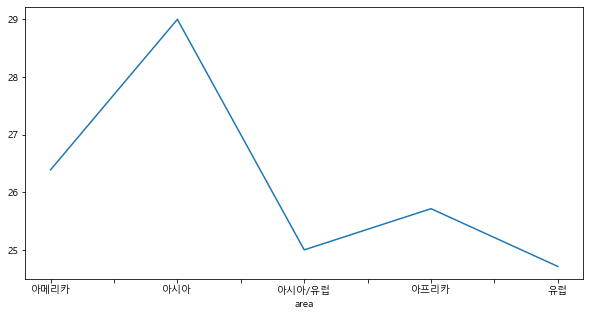

In [17]:
# 대륙별 Top100 선수들의 평균나이
g_area_age = df.groupby(['area'])['age'].mean()
g_area_age.plot(kind='line', figsize=(10,5))
plt.show()

# 아시아가 가장 높고, 유럽이 가장 낮은 것을 알 수 있다. (top100 안에 선수들이 많지 않기 때문에 평균나이는 사실 의미가 없다.)

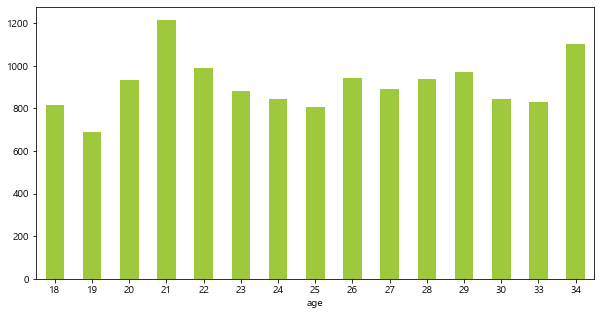

In [30]:
# 세계 Top100의 나이별 평균 시장가치
g = df.groupby(['age'])['marketValue(단위:억)'].mean()
g.plot(kind='bar',rot = 0, figsize=(10,5), color= '#9FC93C')
plt.show()

# 21세 그룹이 가장 높은 시장가치를 가지고 있다.

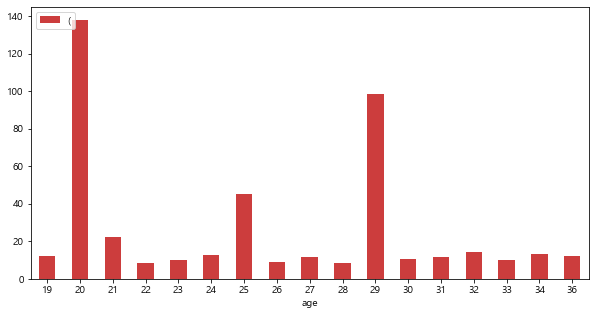

In [37]:
# 한국 선수들의 나이별 평균 시장가치
g = k_df.groupby(['age'])['marketValue(단위:억)'].mean()
g.plot(kind='bar',rot = 0, figsize=(10,5), color= '#CC3D3D')
plt.legend('(단위:억)', loc='upper left')
plt.show()

# 20세 그룹이 가장 높은 시장가치를 가지고 있다.

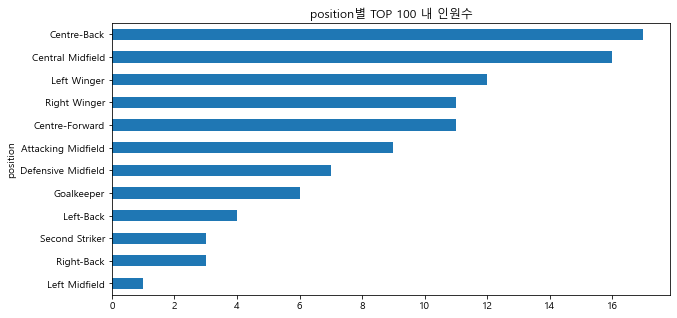

In [39]:
# 세계 Top100 내 포지션 분포
g = df.groupby(['position'])['marketValue(단위:억)'].count().sort_values()
g.plot(kind='barh', figsize=(10,5))
plt.title('position별 TOP 100 내 인원수')
plt.show()

# Centre-Back 포지션이 제일 많이 분포하고 있다.

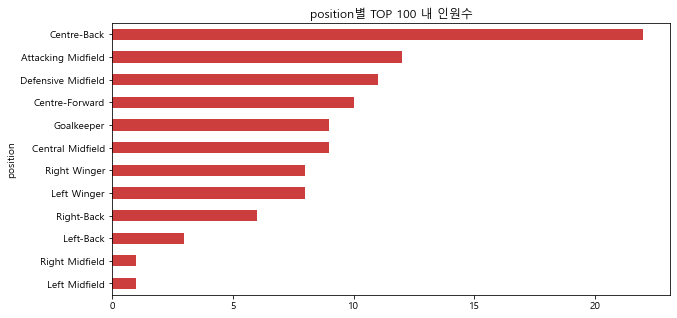

In [42]:
# 우리나라 Top100 내 포지션 분포
g_k = k_df.groupby(['position'])['marketValue(단위:억)'].count().sort_values()
g_k.plot(kind='barh', figsize=(10,5), color= '#CC3D3D')
plt.title('position별 TOP 100 내 인원수')
plt.show()

# Centre-Back 포지션이 제일 많이 분포하고 있다.